# Power Grid Harmonics 🏭⟿🔌

Applying harmonic pattern scanning in stock market charts to the frequency of the UK power grid. 

FOREX Harmonic pattern scanning algorithm tutorial: https://www.youtube.com/watch?v=tGpMb8R9D9M

Elexon Portal/BMRS: https://www.bmreports.com/bmrs/

BMRS API guide: https://www.elexon.co.uk/wp-content/uploads/2017/06/bmrs_api_data_push_user_guide_v1.1.pdf

In [1]:
import requests
from io import StringIO
from datetime import datetime, timedelta
import os

import pandas as pd
import numpy as np
from scipy.signal import argrelextrema

import matplotlib
import matplotlib.pyplot as plt

from harmonic_functions import *

Request the data from the Elexon Portal

In [2]:
# API key stored in an environment variable
key = os.environ['BMRS_key']

# Request dates
now = datetime.now()
start_time = now - timedelta(days=1)
now_string = now.strftime('%Y-%m-%d %H:%M:%S')
start_string = start_time.strftime('%Y-%m-%d %H:%M:%S')

# Build and send request
url = "https://api.bmreports.com/BMRS/FREQ/v1?APIKey="
st = "&FromDateTime=" + start_string
end = "&ToDateTime=" + now_string
r = requests.get(url + key + st + end + "&ServiceType=csv")

# Receive data
df = pd.read_csv(StringIO(r.text))
df.head()

HDR  SYSTEM FREQUENCY DATA
FREQ  20200803215215                 50.024
FREQ  20200803215230                 50.019
FREQ  20200803215245                 50.029
FREQ  20200803215300                 50.012
FREQ  20200803215315                 50.035

In [3]:
# Clean up
df = df.drop(['FTR'])
df['HDR'] = pd.to_datetime(df['HDR'], format='%Y%m%d%H%M%S')
df.rename(columns={'HDR': 'timestamp', 'SYSTEM FREQUENCY DATA':'frequency'}, inplace=True)
df.index = df['timestamp']
del df['timestamp']
print("datapoints: ", df.values.shape)

datapoints:  (5511, 1)


<AxesSubplot:xlabel='timestamp'>

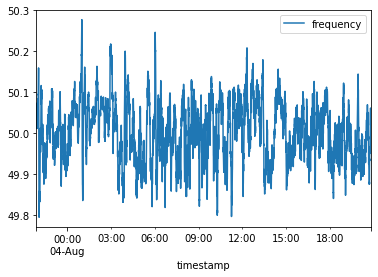

In [4]:
%matplotlib inline
df.plot()

## Harmonic Pattern Finding

In [5]:
max_idx = list(argrelextrema(df.values, np.greater, order=10)[0])
min_idx = list(argrelextrema(df.values, np.less, order=10)[0])
idx = max_idx + min_idx
idx.sort()
peaks = df.values[idx]

In [6]:
# Plot the peaks
plt.plot(df.values)
plt.scatter(idx, peaks, c='r')
plt.show()

In [7]:
err_allowed = 5.0/100

graph_n = 0

plot = {
    "label": "",
    "x": "",
    "values": "",
    "idx": "",
    "pat": "",
    "ax labels": ""
}

In [8]:
# Find patterns
for i in range(100, len(df)):

    current_idx, current_pat, start, end = peak_detect(df.values[:i], order=8)

    XA = current_pat[1] - current_pat[0]
    AB = current_pat[2] - current_pat[1]
    BC = current_pat[3] - current_pat[2]
    CD = current_pat[4] - current_pat[3]

    moves = [XA, AB, BC, CD]

    gart = is_gartley(moves, err_allowed)
    butt = is_butterfly(moves, err_allowed)
    bat = is_bat(moves, err_allowed)
    crab = is_crab(moves, err_allowed)

    harmonics = np.array([gart, butt, bat, crab])
    labels = ['Gartley 📐', 'Butterfly 🦋', 'Bat 🦇', 'Crab 🦀']

    if np.any(harmonics == 1) or np.any(harmonics == -1):
        for index, j in np.ndenumerate(harmonics):
            if j == 1 or j == -1:
                sense = '🐮 Bullish ' if j == 1 else '🐻 Bearish '
                label = sense + labels[index[0]]
                print("spotted a: " + label)

                plot["label"] = label
                plot["x"] = np.arange(start, i+15)
                plot["values"] = df.values[start:i+15]
                plot["idx"] = current_idx
                plot["pat"] = current_pat
                plot["ax labels"] = df.index[current_idx]

spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Bat 🦇
spotted a: 🐻 Bearish Bat 🦇
spotted a: 🐻 Bearish Crab 🦀
spotted a: 🐻 Bearish Bat 🦇
spotted a: 🐻 Bearish Bat 🦇
spotted a: 🐻 Bearish Crab 🦀
spotted a: 🐻 Bearish Bat 🦇
spotted a: 🐻 Bearish Crab 🦀
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Butterfly 🦋
spotted a: 🐮 Bullish Bat 🦇
spotted a: 🐻 Bearish Gartley 📐


🐻 Bearish Gartley 📐


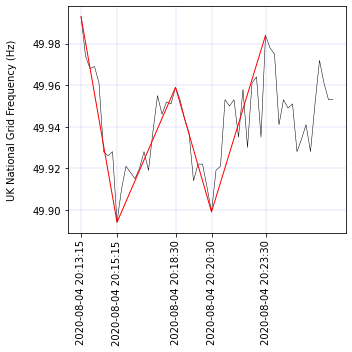

In [9]:
# Plot the latest pattern
fig = plt.figure(figsize=(5,5))

plt.plot(plot["x"], plot["values"], c='k', linewidth=0.5) # frequency
plt.plot(plot["idx"], plot["pat"], c='r', linewidth=1) # pattern

plt.xticks(plot["idx"], plot["ax labels"], rotation='vertical')
plt.yticks()
plt.ylabel("UK National Grid Frequency (Hz)\n")
plt.grid(True, c='b', linewidth=0.1)

plt.tight_layout()
print(plot['label'])
plt.show()